# Hermite Defination: Divergence in the Variance of Jarzynski Estimator of QHO 



In [1]:
# front matter
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import hermite
from math import factorial

# If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina' 

In [2]:
# Basic constants
# grids
N=2000 

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(N//2), np.arange(-N//2,0))) 

# Initial and final trapping frequencies
w1=1 
w0=0.35

# states involved in the simulation
n=30

## Function Defination

### Eigenfunction 


Set $m=\hbar=1$, then the analitical form of the wave function of QHO is following:
$$\psi_v(x)= K_v H_v(\sqrt{\omega} x) e^{-\omega x^2 / 2}$$
where $K_v=\frac{1}{\sqrt{2^v v !}}\left(\frac{ \omega}{\pi}\right)^{1 / 4}$

In [3]:
def psi(w,v):
    Hr=hermite(v)
    if w==0:
        Psix = 1./np.sqrt(np.sqrt(np.pi/w0)*2**v*factorial(v))*Hr(np.sqrt(w0)*X)*np.exp(-0.5*w0*X**2)
    elif w==1:
        Psix = 1./np.sqrt(np.sqrt(np.pi/w1)*2**v*factorial(v))*Hr(np.sqrt(w1)*X)*np.exp(-0.5*w1*X**2)
    normal = np.sqrt(sum(abs(Psix)**2)) # normalization
    return Psix/normal

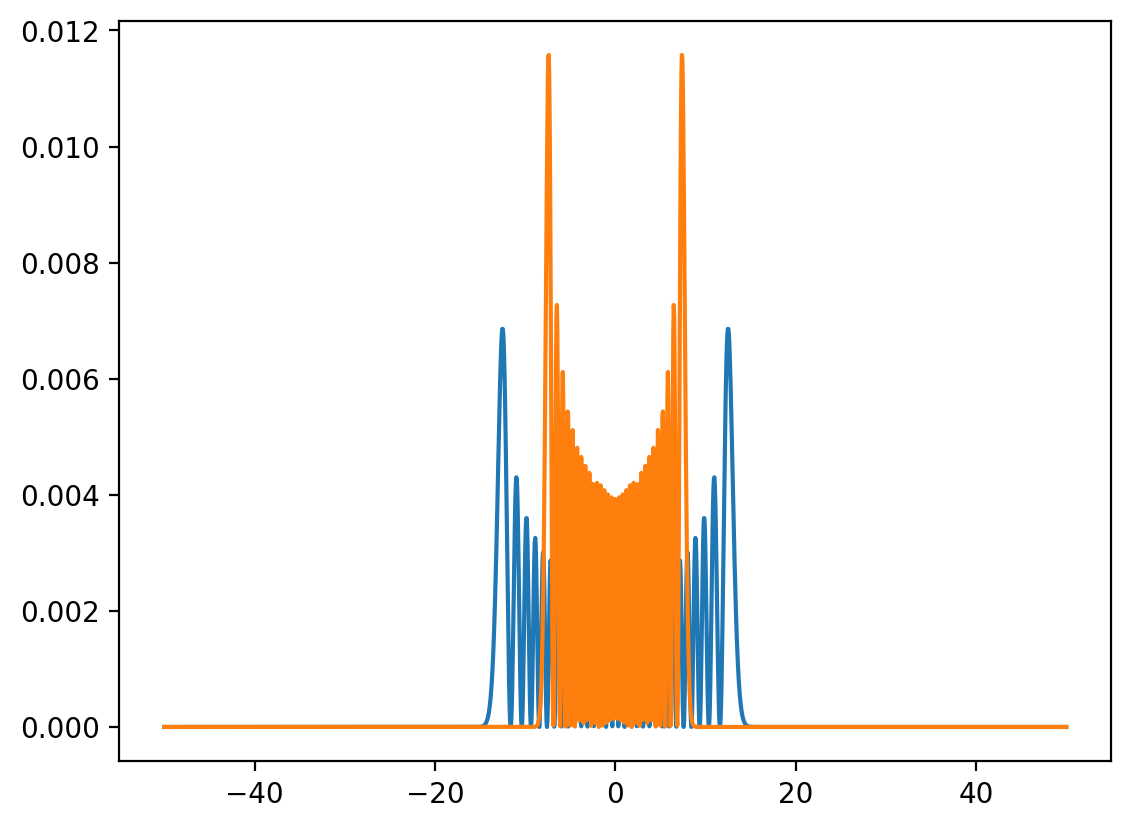

In [4]:
# see an example of wavefunctions
plt.plot(X, np.abs(psi(0,n))**2)  
plt.plot(X, np.abs(psi(1,n))**2)  

### Eigenvalue 


The eigenvalue of a QHO is $\hbar \omega(v+0.5)$

In [5]:
def E(w,v):
    return w0*(v+0.5) if w==0 else w1*(v+0.5)
print(E(1,29))

29.5


### Time operator

In [6]:
def simulation(v,tau,dt):
    M=int(tau/dt)
    psi_0 = psi(0, v)
    for m in range(M):
        UV = np.exp(-1j*(((w0+((w1-w0)/M)*m)*X)**2/2)*dt/2)
        UT = np.exp(-1j*(P**2/2)*dt)  
        psi_1 = UV*psi_0
        phi_2 = np.fft.fft(psi_1)   # wavefunction in momentum space
        phi_3 = UT*phi_2
        psi_3 = np.fft.ifft(phi_3)
        psi_4 = UV*psi_3
        psi_0 = psi_4  # prepare a new cycle
    return psi_0


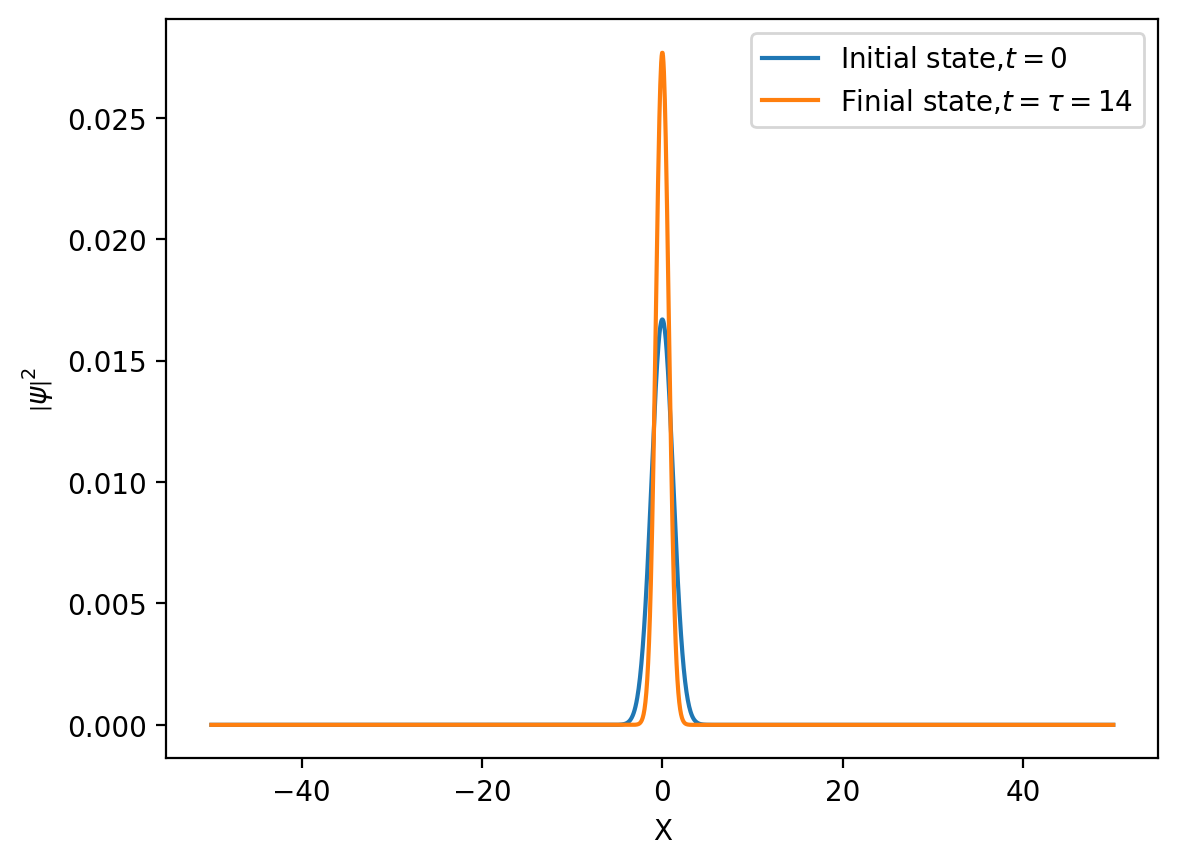

In [7]:
# see an example
plt.plot(X, np.abs(psi(0,0))**2,label='Initial state,$t=0$')  
plt.plot(X, np.abs(simulation(0,14,0.25))**2,label='Finial state,$t=\\tau=14$')

plt.xlabel('X')
plt.ylabel('$\\left|\\psi\\right|^2$')
plt.legend()
plt.show()


### Partition function

In [8]:
def Z(w,beta):
    return sum([np.exp(-beta * E(w,v)) for v in range(n)])

In [9]:
# Example
print(Z(0,6))

0.39876965700346667


### Helmholtz free energy difference $\Delta F$

In [10]:
def delta_F(beta):
    delta_F_0=1/beta*math.log(Z(0,beta)/Z(1,beta))
    return delta_F_0

In [11]:
# Example
print(delta_F(6))

0.34635780684889


## Simulate the variance of Jarzynski Estimator of QHO for different $\hbar \beta$

In [12]:
# beta range from 0.3 to 8
beta_range = np.linspace(0.01, 10, 50)

Function of $\operatorname{var}\left(e^{-\beta W_{\text {dis }}}\right)=\operatorname{var}\left(e^{-\beta W}\right) / e^{-2 \beta \Delta F}$, with simulation time of $\tau$.

In [13]:
def var_list(tau,dt):
    var_list_0 = []
    for beta in beta_range:
        Z0= Z(0,beta)
        DF= delta_F(beta)
        Fm=0.0
        Sm=0.0
        for i in range(n):
            for j in range(n):
                psit=simulation(i,tau,dt)
                psi1=psi(1,j)
                abs_dot= abs(np.dot(psi1,psit))**2
                Fm+=np.exp(-beta*E(1,j))*abs_dot/Z0
                Sm+=np.exp(-beta*(2*E(1,j)-E(0,i)))*abs_dot/Z0
        Var=Sm-Fm**2
        Var_dis=Var/np.exp(-2*beta*DF)
        var_list_0.append(Var_dis)
    return var_list_0

Take $\tau = 1.15$ and $\tau=14$ for an example

In [14]:
var_list_1=var_list(2,0.1)

In [15]:
var_list_2=var_list(15,0.1)

In [16]:
# Time operator
def simulation2(v,wp,tau,dt):
    M = int(tau/dt)
    psi_0 = psi(0, v)
    for m in range(M):
        UV = np.exp(-1j*((wp[m]*X)**2/2)*dt/2)
        UT = np.exp(-1j*(P**2/2)*dt)  
        psi_1 = UV*psi_0
        phi_2 = np.fft.fft(psi_1)   # wavefunction in momentum space
        phi_3 = UT*phi_2
        psi_3 = np.fft.ifft(phi_3)
        psi_4 = UV*psi_3
        psi_0 = psi_4  # prepare a new cycle
    return psi_0

In [17]:
def var_list3(wp,tau,dt):
    var_list_0 = []
    for beta in beta_range:
        Z0= Z(0,beta)
        DF= delta_F(beta)
        Fm=0.0
        Sm=0.0
        for i in range(n):
            for j in range(n):
                psit=simulation2(i,wp,tau,dt)
                psi1=psi(1,j)
                abs_dot= abs(np.dot(psi1,psit))**2
                Fm+=np.exp(-beta*E(1,j))*abs_dot/Z0
                Sm+=np.exp(-beta*(2*E(1,j)-E(0,i)))*abs_dot/Z0
        Var=Sm-Fm**2
        Var_dis=Var/np.exp(-2*beta*DF)
        var_list_0.append(Var_dis)
    return var_list_0

In [18]:
work=[0.35, 0.35387089, 0.36908887, 0.4008702, 0.45557523, 0.54253862, 0.67661064, 0.88098802, 1.18958636, 1.64781994, 2.31020896, 3.23272882, 4.45725073, 5.98479837, 7.73366045, 9.47765518, 10.75903854, 10.76968468, 8.19324387, 1.0]
var_list_3=var_list3(work,2,0.1)

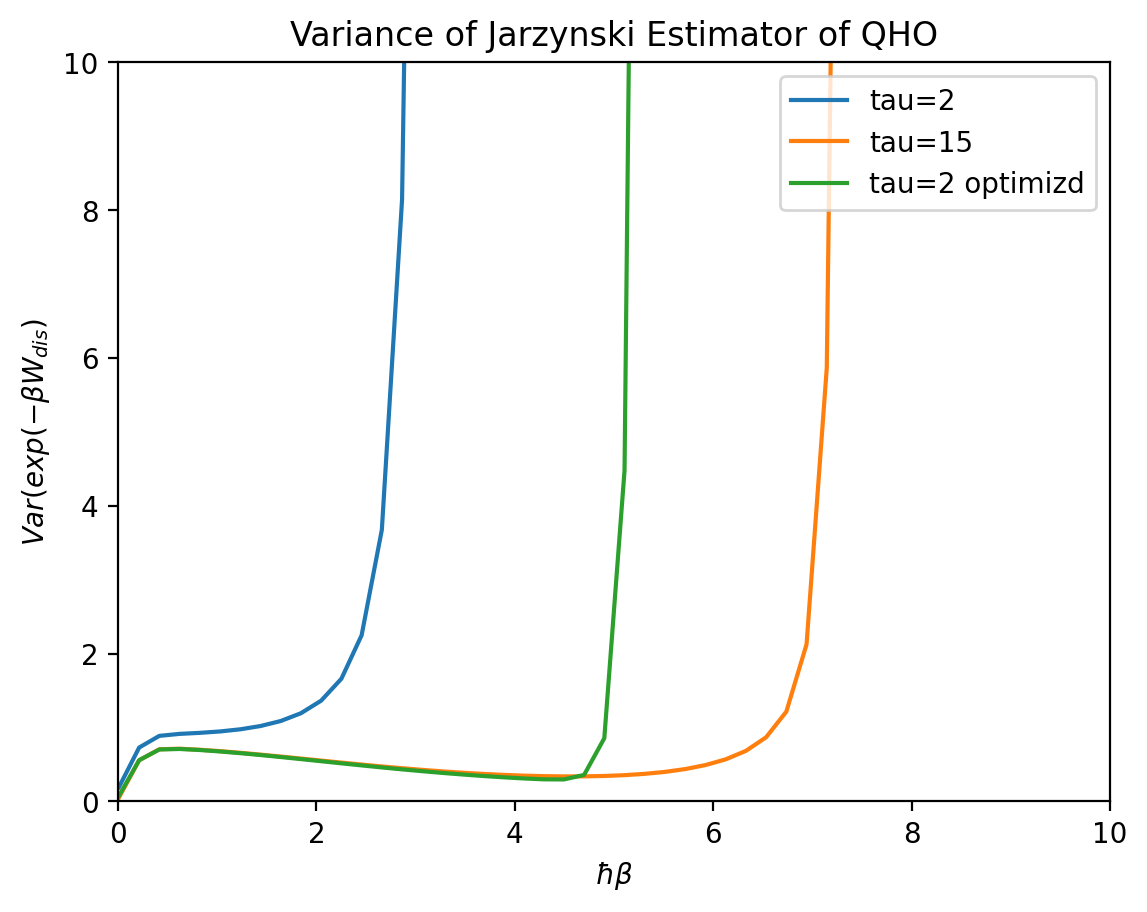

In [19]:
# plot the variance
plt.plot(beta_range, var_list_1, label='tau=2')
plt.plot(beta_range, var_list_2, label='tau=15')
plt.plot(beta_range, var_list_3, label='tau=2 optimizd')



plt.xlabel(r'$ \hbar \beta$')
plt.ylabel(r'$Var(exp(-\beta W_{dis})$')
plt.title('Variance of Jarzynski Estimator of QHO')
plt.ylim(0, 10)
plt.xlim(0, 10)
plt.legend() 
plt.show()